### <p style="text-align: center;">Image Captioning for visually impaired</p>

**Introduction** 
- image captioning is the task of generating text descrptions for input image
- in this notebook we will go through the steps of building a Deep Learning Model that can take an input image and generate text Description for it in Arabic Language

**Data and Tools**
- i will be using the famous flicker8k Data set for this purpose with arabic captions 
- the dataset consists of two parts Image Folder which contains different images and txt files
    - the *.txt* files are 4 files **Flickr8k.arabic.full.txt** which contains name of each image 3 captions for each image and a score provided by experts that denote how accurate the caption is 
    - another 3 files which contain a split of names of images to be used as train/dev/test 
    
- we will build an Encoder-Decoder model using Tensorflow v2 


In [101]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
%matplotlib inline
from PIL import Image
import os
from bidi.algorithm import get_display
import arabic_reshaper
from string import punctuation
import re
from tensorflow import keras
import pathlib
import collections
import einops
import tqdm
import os
from nltk.translate.bleu_score import sentence_bleu,corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
import pickle
from gensim.models import KeyedVectors
from gensim.models import word2vec

we will first write some functions to load our text files and create descriptions dictionary so that it can be used for our analysis before building datasets for Deep Learning

In [102]:
def load_flicker_file(path,file):
    path = pathlib.Path(path)
    print(f"loading file = {file}")
    with open(path/file,'r',encoding='utf-8') as f:
        data = f.read()
        f.close()

    return data

In [103]:
def create_description_dict(data):
    descrptions = {}
    print("Creating descriptions dictionary")
    for line in data.split('\n'):
        data_line = line.split('\t')
        #some lines are missing = ('') so skip if lenght of line is <2
        if len(data_line) < 2:
            continue
        img,caption = data_line
        img_name = img.split('.')[0]
        
        if img_name not in descrptions:
            descrptions[img_name] = list()

        descrptions[img_name].append(caption)

    return descrptions

data = load_flicker_file('data','Flickr8k.arabic.full.txt')
data_descrptions = create_description_dict(data)

loading file = Flickr8k.arabic.full.txt
Creating descriptions dictionary


train val test files
- 3 files that contain images names 
- loading thier captions from descriptions dict
- creating tf dataset for train/val/test

In [104]:
trainimgs = load_flicker_file(path='data',file='Flickr_8k.trainImages.txt').splitlines()
valimgs = load_flicker_file(path='data',file='Flickr_8k.devImages.txt').splitlines()
testimgs = load_flicker_file(path='data',file='Flickr_8k.testImages.txt').splitlines()

traincaptions = [data_descrptions[img_name.split('.')[0]] for img_name in trainimgs]
valcaptions = [data_descrptions[img_name.split('.')[0]] for img_name in trainimgs]
testcaptions = [data_descrptions[img_name.split('.')[0]] for img_name in trainimgs]

print()
print(f"TrainImgs size = {len(trainimgs)}")
print(f"ValidationImgs size = {len(valimgs)}")
print(f"TestImgs size = {len(testimgs)}")

print(f"number of captions per image = {len(traincaptions[0])}")

loading file = Flickr_8k.trainImages.txt
loading file = Flickr_8k.devImages.txt
loading file = Flickr_8k.testImages.txt

TrainImgs size = 6000
ValidationImgs size = 1000
TestImgs size = 1000
number of captions per image = 3


we could see that our data contain 8000 images and each image has 3 captions assoicated with it

Visualizing

- we will take some sample images and plot them with their captions to see how the data looks like

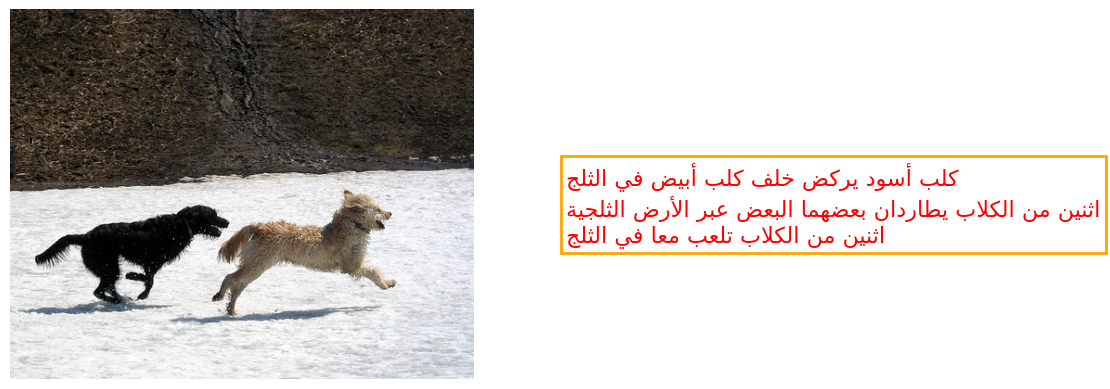

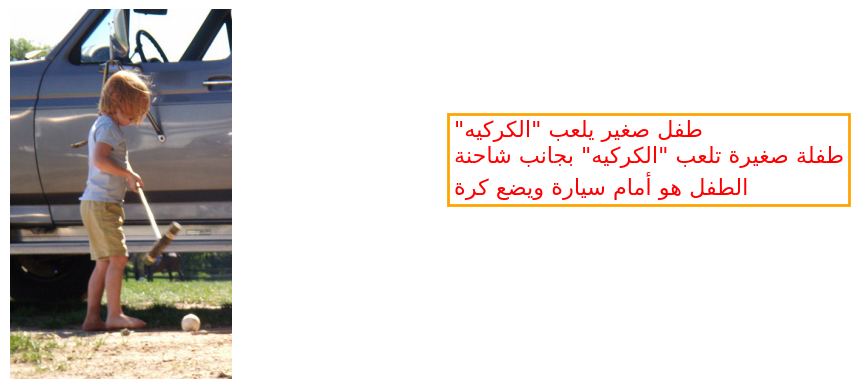

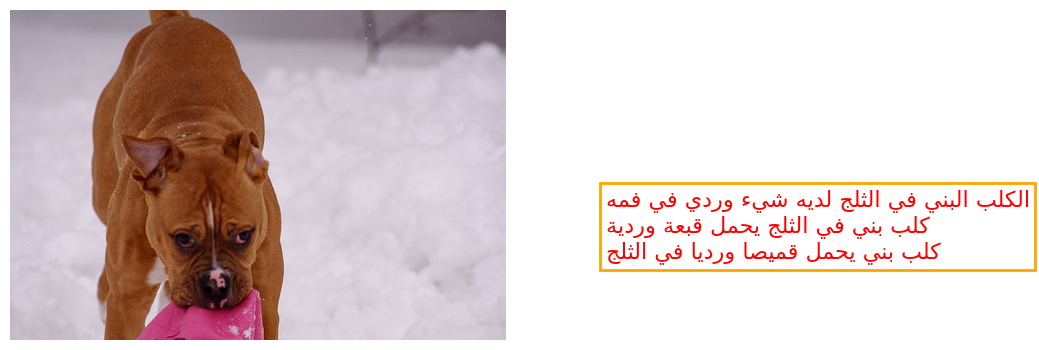

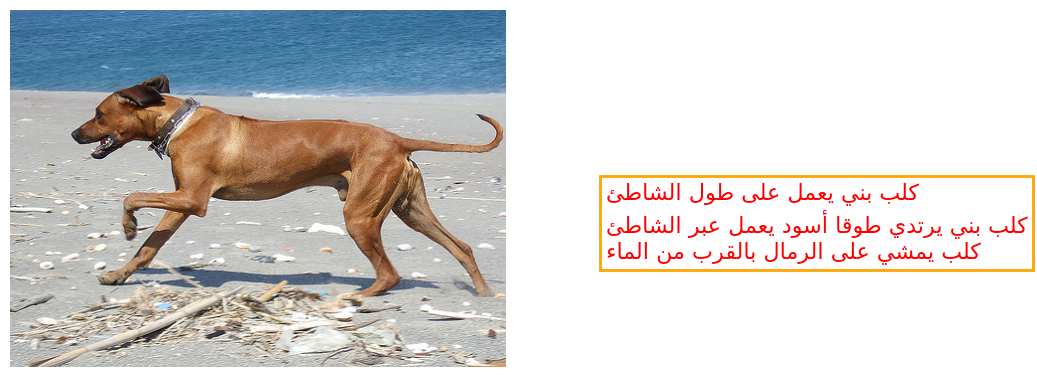

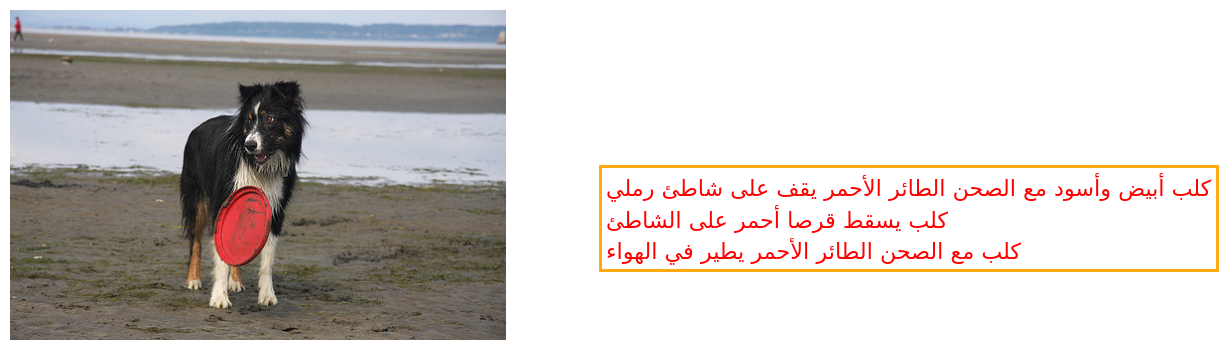

In [105]:
for sample_img,sample_cpt in zip(trainimgs[:5],traincaptions[:5]):
    path = pathlib.Path('data/Images')
    plt.figure()
    img = Image.open(path/sample_img) 
    arabic_caption = [arabic_reshaper.reshape(sample_caption) for sample_caption in sample_cpt]
    cpt = '\n'.join(arabic_caption)
    ar_cpt = get_display(cpt)
    plt.imshow(img)
    plt.text(600, 250,ar_cpt,fontdict={'color':'red','weight':'normal','size':16},bbox=dict(fill=False, edgecolor='orange', linewidth=2))
    plt.axis('off')
    plt.show()

### Preparing Img Data

as discussed earlier the task we will be split into to 2 parts Encoder and Decoder so next we will build our encoder model

**Encoder**
- encoder job will be to take input images and extract features from them, later the decoder will take those features and generate text based on them
- we will be using a pretrained VGG16 model that was trained on large dataset of images and is already Good in extracting features 

**Transfer Learning**
- VGG16 job was to classify images into different categories but since we are building encoder and not intersted in classifcation we will load the model and exclude the last classification softmax layer and use only the convolution layers and add our own dense Layer to output a feature tensor

In [106]:
vgg_encoder = tf.keras.applications.vgg16.VGG16(include_top=True)
vgg_encoder = tf.keras.Model(inputs=vgg_encoder.inputs,outputs=vgg_encoder.layers[-2].output)
vgg_encoder.trainable = False

vgg_encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

Since we know that our traindata contains names of imgs in our directory we will write a function that takes an img path from our dataset and loads the data into a tensor and preprocess the image with vgg16 preprocessing function 

In [107]:
def load_preprocess_img(img_path):
    path = os.path.join('data/Images/',img_path)
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img)
    img = tf.image.resize(img[tf.newaxis,...],[224,224])
    #img = tf.image.resize(img,[224,224])

    img = tf.keras.applications.vgg16.preprocess_input(img)
    return img

In [108]:
img1 = load_preprocess_img('667626_18933d713e.jpg')
img1.shape

TensorShape([1, 224, 224, 3])

in the next graph you can see that the vgg16 preprocess function extracted only useful features from our image pixels that will make our training better

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


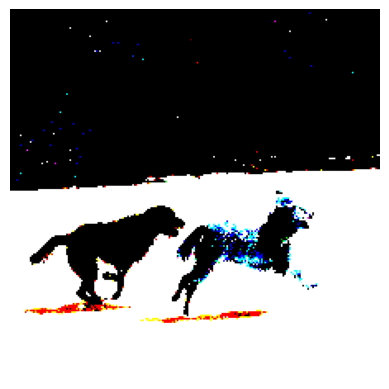

In [109]:
#processed img
plt.imshow(load_preprocess_img(trainimgs[0])[0])
plt.axis('off')
plt.show()

passing the preprocessed img to vgg model to get output tensor of shape (1,4096) -> (batch_size,4096)

In [110]:
#vgg_encoder = EncoderCNN()
vgg_pred = vgg_encoder(img1)
vgg_pred

<tf.Tensor: shape=(1, 4096), dtype=float32, numpy=
array([[0.        , 0.        , 0.        , ..., 0.        , 2.4874604 ,
        0.57602715]], dtype=float32)>

Since we are using a pretrained img model to extract Features from images to pass it to the decoder and we made our img model non-trainable we will run the img model to extract features from all images in our dataset and save it to disk 

- this step will reduce the training time of the entire model 
- note that data_descriptions is a dictionary that contains all of the data files

In [ ]:
img_features = {}

for img in data_descrptions.keys():
    process_img = load_preprocess_img(img+'.jpg')
    pred = vgg_encoder(process_img) #verbose 0 to hide predict bar
    img_features[img] = pred

pickle.dump(img_features, open('img_features_vgg.pkl','wb'))

### Captions Cleaning and Preprocessing

- Decoder training takes as input img Features extracted from the encoder along with it it should take an input sequence of text (more than that later)
- to pass text to Deeplearning Model we need first to convert it from text to number, and the processing of giving each word a numerical reperesntation requires building a vocabulary from our captions data and that will be solved in the following cells

In [111]:
cpts = []
most_frequent_vocab = []
for cpt in data_descrptions.values():
    for cp in cpt:
        cpts.append(cp)

text = ' '.join(cpts)
vocabulary = list(set(text.split()))
for word in vocabulary:
    if text.count(word) >= 5:
        most_frequent_vocab.append(word)
        

print('Unique Words in vocabulary =',len(vocabulary))
print('most Frequent Words in vocabulary =',len(most_frequent_vocab))

Unique Words in vocabulary = 11387
most Frequent Words in vocabulary = 4089


from img1 = [cpt1,cpt2,cpt3],img2 = [cpt1,cpt2,cpt3] ...  to concat of captions into single list [cpts,cpt,cpt]

In [112]:
all_cpts = [caption for img, captions in data_descrptions.items() for caption in captions]

sentences have varying length but since our model needs fixed length input we need to calculate max_len to pad short sentences to it

In [113]:
max_len = 0
sentence_lens = []
for cpt in all_cpts:
    temp = len(cpt.split())
    sentence_lens.append(temp)
    if temp > max_len:
        max_len = temp

print(f'maximum sentence length = {max_len}')

maximum sentence length = 26


In [114]:
unique, counts = np.unique(sentence_lens, return_counts=True)
print('captions lengths in our data')
print('count','occurance')
print(np.asarray((unique, counts)).T)

captions lengths in our data
count occurance
[[   1    2]
 [   2  134]
 [   3  571]
 [   4 2082]
 [   5 3092]
 [   6 3839]
 [   7 3911]
 [   8 3417]
 [   9 2633]
 [  10 1882]
 [  11 1171]
 [  12  642]
 [  13  356]
 [  14  233]
 [  15  137]
 [  16   68]
 [  17   39]
 [  18   34]
 [  19   17]
 [  20    7]
 [  21    1]
 [  22    1]
 [  23    1]
 [  24    2]
 [  26    1]]


we could see from the output that sentences with length > 20 are very rare so we will set max_len to pad to 20

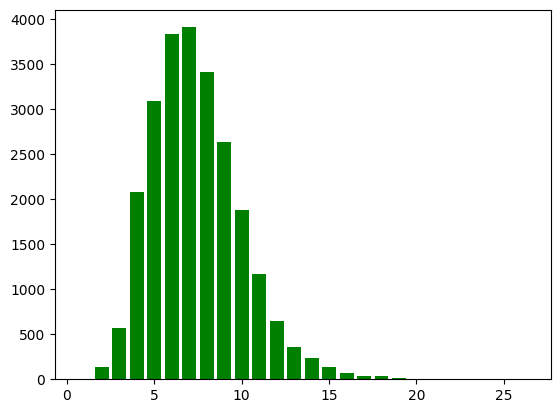

In [115]:
plt.figure()
plt.bar(unique,counts,color='green')
plt.show()
max_len = 20

**Text Cleaning and tokenizing**

- tf.keras has a Vecorization layer that can take our captions as input tokenize them to words
- the layer then builds a vocabulary from our words which we specify as the number of most_frequent_vocabulary
- the layer then maps each word to a index number and pads all the sentences to max_len so they all have same length
- the layer can take as input a standrdize function that can perform text cleaning operations on each word in the vocabulary

**Standardize**
- performs various text operations such as lemmitization which is reducing verbs to it's base
- removing different arabic punctuations 
- removing arabic discritization and normiling chars to thier base 
    - example " ا إ أ " are the same letter so they are normlized to "ا"  
- padding each caption with [start] and [end] tokens to denote start and end of a sequence


In [116]:
def standardize(s):
    arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
    english_punctuations = punctuation

    #s = tf.strings.regex_replace(s, f'[{re.escape(arabic_punctuations)}]', ' ')
    s = tf.strings.regex_replace(s, f'[{re.escape(punctuation)}]', ' ')
    s = tf.strings.regex_replace(s, b'\xd9\x91', ' ')
    s = tf.strings.regex_replace(s, b'\xd9\x92', ' ')
    s = tf.strings.regex_replace(s, b'\xd9\x8c', ' ')
    s = tf.strings.regex_replace(s, b'\xd9\x8d', ' ')
    s = tf.strings.regex_replace(s, b'\xd9\x8e', ' ')
    s = tf.strings.regex_replace(s, b'\xd9\x8f', ' ')
    s = tf.strings.regex_replace(s, b'\xd9\x90', ' ')
    s = tf.strings.regex_replace(s,b"[\xd8\xa2]", b"\xd8\xa7")
    s = tf.strings.regex_replace(s,b"[\xd8\xa3]", b"\xd8\xa7")
    s = tf.strings.regex_replace(s,b"[\xd9\xb1]", b"\xd8\xa7")
    s = tf.strings.regex_replace(s,b"[\xd8\xa5]", b"\xd8\xa7")
    s = tf.strings.regex_replace(s,b"\xd9\x89", b"\xd9\x8a")
    s = tf.strings.regex_replace(s,b'\xd8\xa9', b"\xd9\x87")  # replace ta2 marboota by ha2
    s = tf.strings.regex_replace(s,b"\xda\xaf", b"\xd9\x83")
    s = tf.strings.regex_replace(s,b'\xd8\xa7\xd9\x84', ' ')
    s = tf.strings.join(['[بدايه]', s , '[نهايه]'],separator=' ')
    
    return s

In [16]:
vocab_size = len(most_frequent_vocab)
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,
    standardize=standardize,
    output_sequence_length=max_len,
)

In [ ]:
tokenizer.adapt(all_cpts)


saving tokenizer to disk

In [ ]:
import pickle
with open('tokenizer-2.pkl','wb') as f:
    pickle.dump({'config':tokenizer.get_config(),
                'weights':tokenizer.get_weights()},f)
    f.close()

In [117]:
with open('tokenizer-2.pkl','rb') as f:
    from_disk = pickle.load(f)
    f.close()
tokenizer = tf.keras.layers.TextVectorization.from_config(from_disk['config'])
tokenizer.set_weights(from_disk['weights'])

creating word_to_index and index_to_word lookups to map words to thier indices and vice-versa

In [118]:
word_to_idx = tf.keras.layers.StringLookup(mask_token="",vocabulary=tokenizer.get_vocabulary())
idx_to_word = tf.keras.layers.StringLookup(mask_token="",vocabulary=tokenizer.get_vocabulary(),invert=True)

In [119]:
#example tokeinztion of 2 sentences
t = tokenizer([['كلب أسود يركض خلف كلب أبيض في الثلج'], ['اثنين من الكلاب يطاردان بعضهما البعض عبر الأرض الثلجية']])
t

<tf.Tensor: shape=(2, 20), dtype=int64, numpy=
array([[   3,    7,   20,   28,  218,    7,   17,    4,   38,    2,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   3,   34,    6,   30, 1241,  210,   58,   43,  135,  257,    2,
           0,    0,    0,    0,    0,    0,    0,    0,    0]],
      dtype=int64)>

**tf.data.Dataset**

- using the data api to build tensorflow datasets from our lists of data
- tf.data provides us with methods such as building a data set from a generator and prefetch which speeds up loading of next batch

In [120]:
trainimgtensor = tf.data.Dataset.from_tensor_slices(trainimgs)
traintoktensor = tf.data.Dataset.from_tensor_slices(traincaptions)

devimgtensor = tf.data.Dataset.from_tensor_slices(valimgs)
devtoktensor = tf.data.Dataset.from_tensor_slices(valcaptions)

testimgtensor = tf.data.Dataset.from_tensor_slices(testimgs)
testtoktensor = tf.data.Dataset.from_tensor_slices(testcaptions)

print('ex_img,ex_captions')
for img in trainimgtensor.take(1):
    print(img)

for caps in traintoktensor.take(1):
    for cap in caps:
        print(cap.numpy().decode('utf-8'))


ex_img,ex_captions
tf.Tensor(b'2513260012_03d33305cf.jpg', shape=(), dtype=string)
كلب أسود يركض خلف كلب أبيض في الثلج
اثنين من الكلاب يطاردان بعضهما البعض عبر الأرض الثلجية
اثنين من الكلاب تلعب معا في الثلج


In [121]:
img_features = pickle.load(open('img_features_vgg.pkl', 'rb'))

**Generator**
- to feed data to our decoder as mentioned earlier we need to provide input sequence and output sequence, we wll give the model an image and a [start] word and ask it to predict the next word and then the next until it predicts an [end] of sequence
- to train our model to do that we will need to give data like this so we take the first word of a caption and give it as a start of sequence as input and the next word in that caption as output so the model can determine what word comes after the other in the sequence
- this process will yield for each caption a (19,20) inputs and a (19,4089) outputs and since Dataset contains 6000 imgs and each img has 3 captions so that's a total of 18000 caption for each a (19,20) sequnce that's alot of data that can't be fit into memory easily 
- we will be using data generator to yield data in batches for our tensorflow model and prefetch batches at each epoch

In [122]:
def generate_ds(X,y,batch=3):
    def gen():
        n=0
        in_imgs,in_toks,out_toks = list(),list(),list()
        
        for imgs,captions in zip(X,y):
            n += 1
            _img = img_features[tf.strings.split(imgs,'.')[0].numpy().decode('utf-8')]
            for caption in captions:

                toks = tokenizer(caption)
                for count in tf.range(1,len(toks)):
                    ins= toks[:count]
                    outs = toks[count]
                    ins = tf.keras.utils.pad_sequences([ins],max_len,padding='post')[0]
                    outs_ = tf.one_hot(outs,tokenizer.vocabulary_size())

                    in_imgs.append(_img)
                    in_toks.append(ins)
                    out_toks.append(outs_)

                if n==batch:
                    yield (tf.squeeze(tf.convert_to_tensor(in_imgs)),tf.convert_to_tensor(in_toks)),tf.convert_to_tensor(out_toks)
                    n=0
                    in_imgs,in_toks,out_toks = list(),list(),list()
                    
    ds = tf.data.Dataset.from_generator(gen,output_signature=(
            (tf.TensorSpec(shape=(None,4096)),
            tf.TensorSpec(shape=(None,max_len),dtype=tf.int32)),
            tf.TensorSpec(shape=(None,tokenizer.vocabulary_size()))
            ))
    
    return ds

      

In [123]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = generate_ds(trainimgtensor,traintoktensor).prefetch(buffer_size=AUTOTUNE)
dev_ds = generate_ds(devimgtensor,devtoktensor).prefetch(buffer_size=AUTOTUNE)
test_ds = generate_ds(testimgtensor,testtoktensor).prefetch(buffer_size=AUTOTUNE)


**Embeddings**
- word emmbeddings are high dimensional vector reperesentation of words that capture corrleation between words
- instead of training embedding layer from scratch to learn embeddings for our vocab we will load pre-trained word embeddings Aravec which returns 300 long vector and save the weights to our emmbedings layer

---

**reference [ARAVec](https://github.com/bakrianoo/aravec)**

---

In [124]:
w2v_embeddings_index={}
TOTAL_EMBEDDING_DIM=300
embeddings_file='./full_grams_cbow_300_twitter/full_grams_cbow_300_twitter.mdl'
w2v_model =KeyedVectors.load(embeddings_file)
for word in w2v_model.wv.key_to_index:
    w2v_embeddings_index[word] = w2v_model.wv[word]
print('Loaded %s word vectors.'% len(w2v_embeddings_index))
pickle.dump(w2v_embeddings_index, open('araVec.pkl','wb'))

Loaded 1476715 word vectors.


In [ ]:
w2v_embeddings_index = pickle.loads(open('araVec.pkl','wb'))


In [125]:
embedding_matrix = np.zeros((tokenizer.vocabulary_size(), TOTAL_EMBEDDING_DIM))
for i, word in enumerate(tokenizer.get_vocabulary()):
    embedding_vector = w2v_embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print('Embedding Matrix shape:', embedding_matrix.shape)

Embedding Matrix shape: (4089, 300)


**Decoder**

- Decoder consists of stack of LSTM units and Dense units
- it will take as input a state vector from the encoder which is Feature reperesntation of shape (1,4096)
- as with the nature of LSTM that they contain 2 cells hidden cell and a state cell we pass the encoder input to the states and stack another LSTM layer after it 
- output is then passed to fully connected network which in the final output takes a 4089 logits (which is the size of our vocabulary) and we compute the argmax to get the sequence values (remmeber we transformed our out_sequence values to one_hot_encoded in the generator function now we transform back in the predictions)

In [126]:
class Decoder(tf.keras.models.Model):
    def __init__(self,vocab_size,units=256):
        super(Decoder,self).__init__()
        self.embed = tf.keras.layers.Embedding(tokenizer.vocabulary_size(),300,weights=[embedding_matrix],trainable=False,mask_zero=True)
        self.lstm = tf.keras.layers.LSTM(units)
        self.fc1 = tf.keras.layers.Dense(units,activation='tanh',name='EncoderCNN') 
        self.fc2 = tf.keras.layers.Dense(units,activation='relu',name='output1') 
        self.dropout = tf.keras.layers.Dropout(0.3)
        self.fc3 = tf.keras.layers.Dense(vocab_size,activation='softmax',name='softmax') ##output Sequence

    def call(self,inputs):
        input_img,input_token = inputs

        encoder_input = self.dropout(input_img)
        encoder_input = self.fc1(encoder_input)    

        decoder_input = self.embed(input_token)
        #decoder_input = self.dropout(0.3)
        
        x = self.lstm(decoder_input,initial_state=[encoder_input,encoder_input])
        x = self.fc2(x)
        x = self.fc3(x)
        
        return x

    def simple_gen(self,image):
        in_text = '[بدايه]'
        for i in range(20):
            #print(in_text)
            sequence = [word_to_idx(w) for w in in_text.split() if w in tokenizer.get_vocabulary()]
            sequence = tf.keras.utils.pad_sequences([sequence], maxlen=20)
            yhat = self((image,sequence))
            yhat = np.argmax(yhat)
            word = idx_to_word(yhat)
            in_text += ' ' + word.numpy().decode('utf-8')
            if word == '[نهايه]':
                break
        caption_prediction = in_text.split()
        caption_prediction = caption_prediction[1:-1]
        caption_prediction = ' '.join(caption_prediction)
        return caption_prediction

In [127]:
model = Decoder(vocab_size=tokenizer.vocabulary_size())

**Callbacks and Metrics**
- Metrics
    - during training and validation we will pass tensorflow CategoricalAccuracy class in metrics since we are using categorical_crossentropy loss function and our outputs is categorical logits of (1,4089) categoricalaccuracy will do the job
    - to make sure our model is really better we will evaluate on the model on the test set and generate predictions and evaluate the test set with bleu-score metric which is a more accurate score regarding text as it calculate given prediction and list of references how close is the prediction to the reference captions

- callbacks
    - generate prediction callback will be used to generate caption for a single test image during training on the end of each epoch to keep track of improvents in prediction on each epoch and outputs bleu-score
    - tensorboard callback to load tensorboard after training for analysis and metrics 
    - checkpoint callback to save best model weights each epoch


In [128]:
class generate_Prediction_bleu(tf.keras.callbacks.Callback):
    def __init__(self):
        image_url = 'https://tensorflow.org/images/surf.jpg'
        image_path = keras.utils.get_file('surf.jpg',origin=image_url)
        image = load_preprocess_img(image_path)
        self.image = vgg_encoder(image)

        
    def on_epoch_end(self, epoch, logs=None):
        references = ['رجل يمارس رياضة ركوب الأمواج']
        hypotheses = []
        print()
        print()
        
        result = self.model.simple_gen(self.image)
        hypotheses.append(result)
        print(result)
            
        chencherry = SmoothingFunction()
        b1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0),smoothing_function=chencherry.method1)
        b2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0),smoothing_function=chencherry.method1)
        b3 = corpus_bleu(references, hypotheses, weights=(0.333, 0.333, 0.333, 0),smoothing_function=chencherry.method1)
        b4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25),smoothing_function=chencherry.method1)
 
        print('Bleu-Scores: ', b1,b2,b3,b4)

        print()

In [49]:
g = generate_Prediction_bleu()
g.model = model
g.on_epoch_end(0)



شل شل شل اختبار شل شل اختبار شمس يجلسون مجموعه حفر يواجهان ذهبي مرتديه نحل يمص خشبي واثنان واثنان
Bleu-Scores:  0.10309278350515462 0.010362833403620979 0.004861012426911579 0.0033115124598129906



path for tensorboard logs

In [129]:
import os
root_log_dir = os.path.join(os.curdir,'my_logs')
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H-%M-%S")
    return os.path.join(root_log_dir,run_id)

adding learning rate schdueler to Adam to decay learning rate going forward through epoch steps

In [130]:
run_log_dir = get_run_logdir()
tb_callback = keras.callbacks.TensorBoard(run_log_dir)
genp = generate_Prediction_bleu()
initial_learning_rate = 0.001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=250,
    decay_rate=0.96,
    staircase=True)

callbacks = [tb_callback,genp] 

In [131]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), loss='categorical_crossentropy',metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [132]:
steps_per_epoch = len(trainimgs) // 3
val_steps_per_epoch = len(valimgs) // 3
epochs = 5

**Training**

- we will use the repeat method to make more batchs for epochs number
- we will train first for 5 epochs and save the model

In [54]:
history = model.fit(train_ds.repeat(epochs),
                    validation_data=(dev_ds.repeat(epochs)),
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=val_steps_per_epoch,
                    verbose=1,
                    epochs=epochs,
                    callbacks=callbacks)

Epoch 1/5
2000/2000 [==============================] - ETA: 0s - loss: 2.1269 - categorical_accuracy: 0.6522

رجل يرتدي قبعه سوداء في قميص احمر و اسود
Bleu-Scores:  0.25 0.025318484177091663 0.011956981879272027 0.008217174698420203

2000/2000 [==============================] - 1962s 975ms/step - loss: 2.1269 - categorical_accuracy: 0.6522 - val_loss: 1.9269 - val_categorical_accuracy: 0.6561
Epoch 2/5
2000/2000 [==============================] - ETA: 0s - loss: 1.7105 - categorical_accuracy: 0.6763

رجل يرتدي خوذه زرقاء يركب دراجه ناريه في هواء
Bleu-Scores:  0.2 0.021320071635561048 0.010233595613566482 0.0070829616979508955

2000/2000 [==============================] - 1803s 901ms/step - loss: 1.7105 - categorical_accuracy: 0.6763 - val_loss: 1.8144 - val_categorical_accuracy: 0.6609
Epoch 3/5
2000/2000 [==============================] - ETA: 0s - loss: 1.5561 - categorical_accuracy: 0.6878

رجل يرتدي خوذه سوداء يركب امواج
Bleu-Scores:  0.3548387096774194 0.034391796971439736 0.01604

In [135]:
history.history['loss']

[2.1268749237060547,
 1.7105449438095093,
 1.5561039447784424,
 1.4526382684707642,
 1.381348967552185]

In [136]:
history.history['val_loss']

[1.9268525838851929,
 1.8144471645355225,
 1.7531646490097046,
 1.7183570861816406,
 1.6954525709152222]

In [ ]:
%load_ext tensorboard

In [137]:
%tensorboard --logdir=./_logs --port=6006

UsageError: Line magic function `%tensorboard` not found.


In [55]:
model.save_weights('./final_model2/checkpoint')

In [61]:
preds = model.evaluate(test_ds)

333/333 [==============================] - 254s 763ms/step - loss: 1.6934 - categorical_accuracy: 0.6695


In [149]:
model.load_weights('./final_model2/checkpoint')

let's train for 5 more epochs

In [150]:
history2 = model.fit(train_ds.repeat(epochs),
                    validation_data=(dev_ds.repeat(epochs)),
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=val_steps_per_epoch,
                    verbose=1,
                    epochs=epochs,
                    callbacks=callbacks)

Epoch 1/5
 172/2000 [=>............................] - ETA: 23:39 - loss: 1.3400 - categorical_accuracy: 0.7047

In [ ]:
model.save_weights('./final_model2/checkpoint')

Train and validation Loss

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "c:\Users\moham\miniconda3\lib\site-packages\keras\backend.py", line 5087, in <genexpr>
    output_ta_t = tuple(  File "c:\Users\moham\miniconda3\lib\site-packages\tensorflow\python\util\tf_should_use.py", line 243, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),


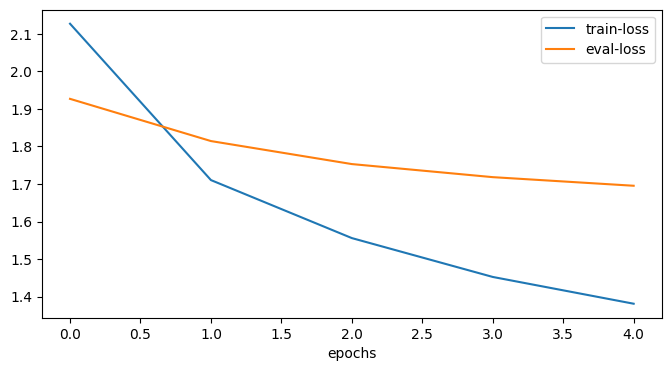

In [148]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'],label='train-loss')
plt.plot(history.history['val_loss'],label='eval-loss')
plt.xlabel('epochs')
plt.legend()
plt.savefig('loss.png')
plt.show()

**Predictions and Testing**

- we trained the model on the train and dev sets now let's make some predictions using images from the test set and evaluate bleu score

In [98]:
def evaluate_bleu(ds,ds_labels):
    refs =[]
    hypo = []
    b_scores = []
    i=0
    for (img,capts) in zip(ds,ds_labels):
        img = img_features[img.split('.')[0]]
        preds =[]
        refs.append(capts)
        result = model.simple_gen(img)
        hypo.append(result)
    
    chencherry = SmoothingFunction()

    b_score = corpus_bleu(refs,hypo,weights=(1, 0, 0, 0),smoothing_function=chencherry.method1)
    

    return tf.data.Dataset.from_tensor_slices([b_score])

In [ ]:
test_bleu_scores = evaluate_bleu(testimgs,testcaptions)

In [100]:
print("bleu-score on test-set =",list(test_bleu_scores.as_numpy_iterator())[0])


bleu-score on test-set = 0.6695868


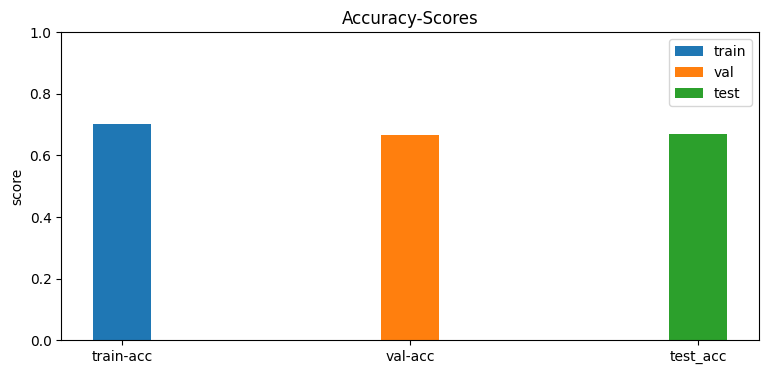

In [65]:
plt.figure(figsize=(9,4))
plt.title('Accuracy-Scores')
plt.bar(['train-acc'],[history.history['categorical_accuracy'][-1]],[0.2,0.2],label='train')
plt.bar(['val-acc'],[history.history['val_categorical_accuracy'][-1]],[0.2,0.2],label='val')
plt.bar(['test_acc'],[preds[1]],[0.2,0.2],label='test')
plt.ylabel('score')
plt.legend()
plt.ylim(0,1)
plt.savefig('accuracy.png')
plt.show()

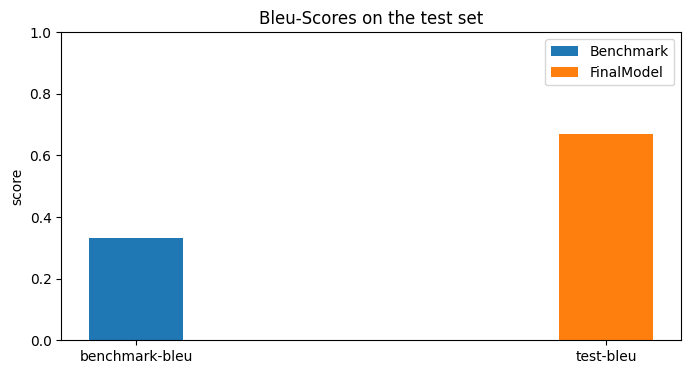

In [147]:
plt.figure(figsize=(8,4))
plt.title('Bleu-Scores on the test set')
plt.bar(['benchmark-bleu'],[0.331881387166974],[0.2,0.2],label='Benchmark')
plt.bar(['test-bleu'],[list(test_bleu_scores.as_numpy_iterator())[0]],[0.2,0.2],label='FinalModel')

plt.ylabel('score')
plt.legend()
plt.savefig('bleu.png')
plt.ylim(0,1)
plt.show()

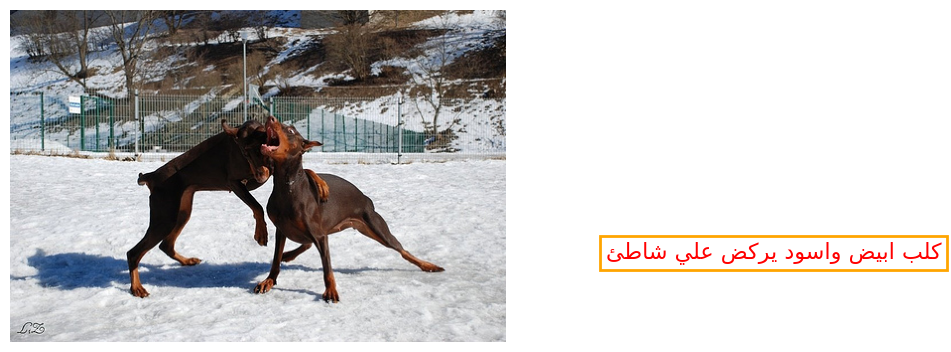

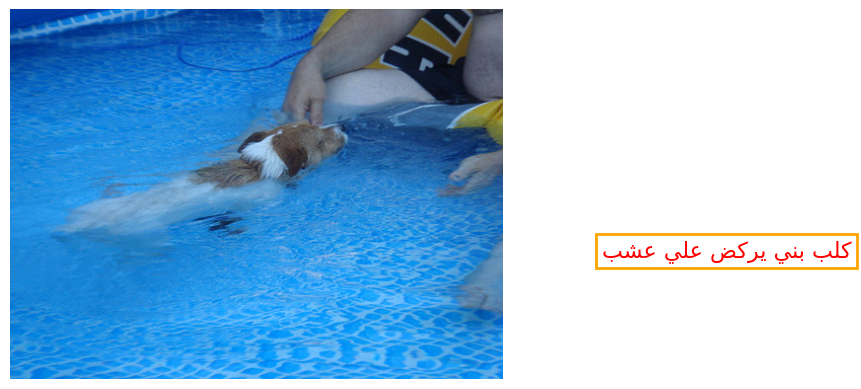

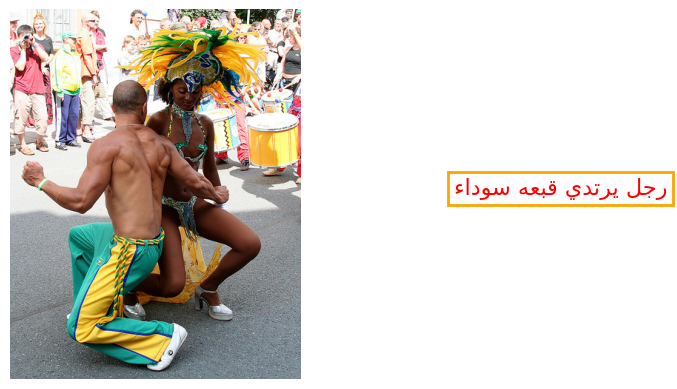

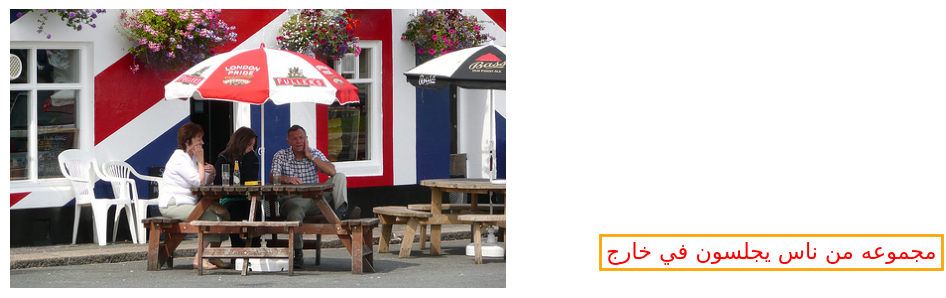

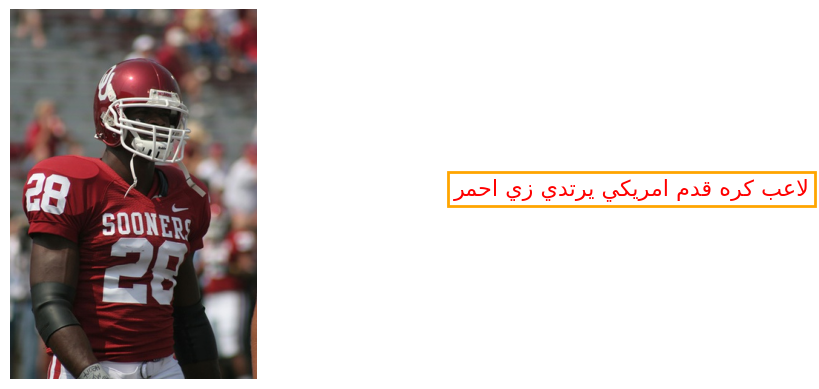

In [57]:
for img in testimgs[:5]:
    generated_caption = model.simple_gen(img_features[img.split('.')[0]])
    path = pathlib.Path('data/Images')
    plt.figure()
    img = Image.open(path/img) 
    arabic_caption = arabic_reshaper.reshape(generated_caption)
    ar_cpt = get_display(arabic_caption)
    plt.imshow(img)
    plt.text(600, 250,ar_cpt,fontdict={'color':'red','weight':'normal','size':16},bbox=dict(fill=False, edgecolor='orange', linewidth=2))
    plt.axis('off')
    plt.show()

output prediction to mp3 

In [ ]:
from gtts import gTTS   

myobj = gTTS(text=generated_caption, lang='ar', slow=False) 
  

myobj.save("output.mp3") 
  

os.system("start output.mp3") 

**Conclusion**

- with just training for 5 epochs the model made pretty accurate predictions on the test set for example in the first picture in the test set it managed to predict that dogs are playing outside but on beach not a bridge, with the last picture it managed to predict an america football player wearing red suit that's pretty accurate

- some of the pictures the model didn't capture enough information from it, to increase the model performance further we could make use things like
    - train for more epochs with decaying learning rate since we only trained for fewer epochs
    - get more data since we only trained on 8k data samples getting more diverse data will help the model generalize much better